# Neural Nets, Stock Prices, and the Fourier Transform


Stock prices are notoriously difficult to forecast, and there is good reason for this. For starters, there isn't even agreement on how to classify the nature of price movement. While many believe price movements are essentially random (and thus have no predictive value), others insist there exists patterns and derived indicators that can nullify the efficient market hypothesis (just ask any technical analyst).

I'm not here to take a side, but rather to just state the facts: traditional methods of price forecasting (including ARIMA, RNNs, and everything else inbetween) are lackluster at best to solve this problem.

This led me to think about price movement a bit differently. I asked myself the quesiton: What if we viewed prices as a wave?

Long story short, this led me to analyzing prices using the fourier transform. 

For those of you who don't know, this set of equations allows you to translate signals in the time domain (a timeseries) into the frequency domain, and vice versa via the inverse fourier transform. 

This is useful for several reasons. First off, analyzing a signal in the frequency domain allows you to see the periodicity of a signal. To state this a different way, it allows you to see how often a wave oscillates within a specified period of time. Furthermore, the Fourier Tranform allows you to decompose a signal in the time domain into the simple sum of its sinusoid constituents. 

For example, imagine a musician playing an angsty A-Minor chord on the piano. Using the Fourier transform, we can essentialy break down this chord into its constituents parts, namely the notes "A", "C", and "E". This can be demonstrated below.



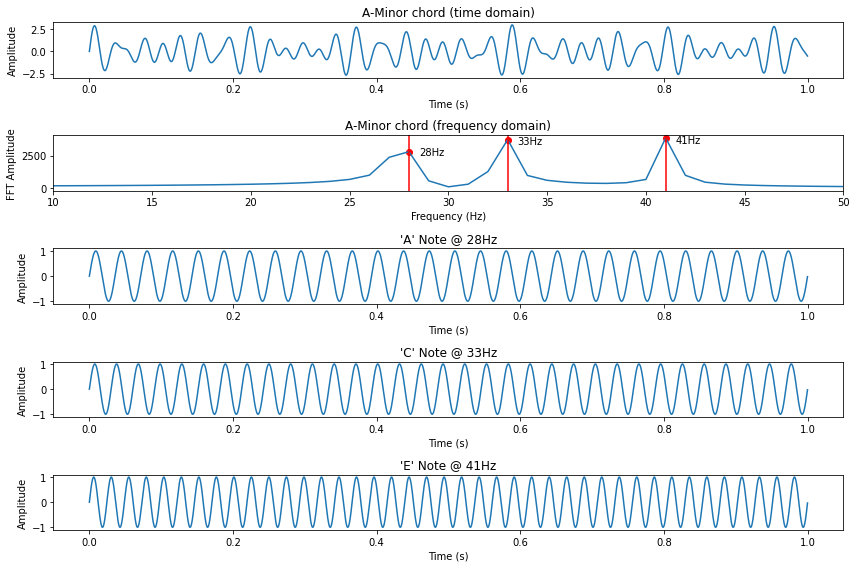

In [7]:
from typing import *
import math
import numpy as np
import pandas as pd
import scipy.fft
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


#frequencies of a, c, e -- the notes that make up an a-minor chord
a_minor = {"a": 27.59, "c": 32.70, "e": 41.20} 

#we set the sample rate equal to the least common multiple of the fractional portion of the frequencies
sample_rate = math.lcm(59, 70, 20)
x = np.linspace(0, 1, sample_rate, endpoint=False)
#a chord is the sum of of individual notes
chord = [] 
for note, freq in a_minor.items():
    y = np.sin(2 * np.pi * freq * x)
    chord.append(y)
chord = np.sum(chord, axis=0)

plt.figure(figsize=(12,8))
plt.subplot(5, 1, 1)
plt.plot(x, chord)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.title("A-Minor chord (time domain)")

#use the fast fourier transform to translate into the frequency domain
fft = scipy.fft.rfft(chord)
fft_abs = np.abs(fft)
fft_freq = scipy.fft.rfftfreq(sample_rate, 1/sample_rate)

#index of peaks --- should roughly correlate to the whole number part of note frequencies 
peaks = find_peaks(fft_abs)[0] 

plt.subplot(5, 1, 2)
plt.plot(fft_freq, fft_abs)
plt.xlim(10, 50)
plt.ylabel('FFT Amplitude')
plt.xlabel('Frequency (Hz)')
plt.scatter(peaks, fft_abs[peaks], c="red")
for peak in peaks:
    plt.axvline(peak, c="red")
    plt.text(peak+0.5,fft_abs[peak]*0.9, f"{peak}Hz")
plt.title("A-Minor chord (frequency domain)")

#for simplicity, round our frequencies and reverse keys/values to query this dictionary by freq
a_minor_whole = dict([(round(freq), note) for note, freq in a_minor.items()])

for i, freq in enumerate(peaks):
    x = np.linspace(0, 1, sample_rate, endpoint=False)
    y = np.sin(2 * np.pi * freq * x)
    plt.subplot(5, 1, i+3)
    plt.plot(x,y)
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plt.title(f"'{a_minor_whole[freq].upper()}' Note @ {freq}Hz")

plt.tight_layout()
plt.show()



And now lets reconstruct our original A-Minor chord using the inverse Fourier Transform

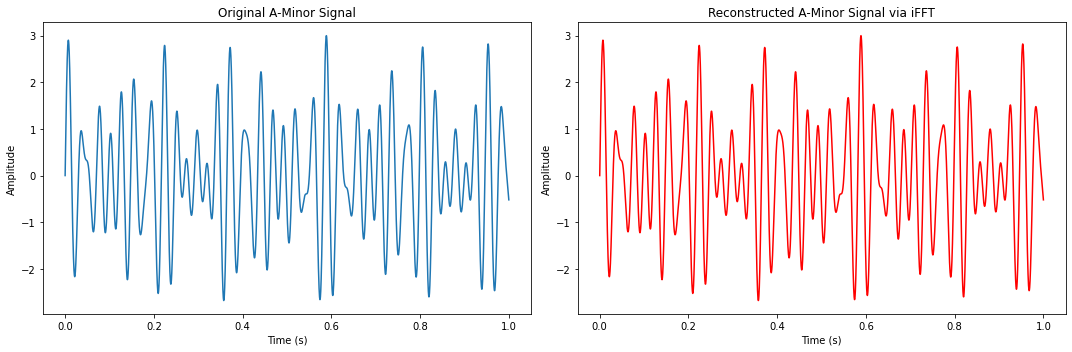

In [2]:
#reconstruct original chord using inverse DFt
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(x, chord)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title("Original A-Minor Signal")

plt.subplot(122)
plt.plot(x, scipy.fft.irfft(fft), c="red")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title("Reconstructed A-Minor Signal via iFFT")
plt.tight_layout()
plt.show()


Let us now take a look at a sample time series. We have already seen with our A-minor chord example that the Fourier transform, and its inverse, can be used to interpolate data perfectly. But can we also use this technique for effective extrapolation?



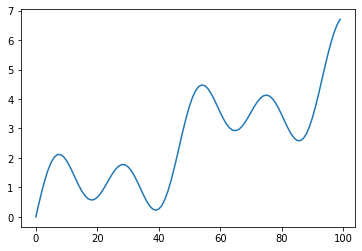

In [46]:
t = np.linspace(0, 1, 100)
X = np.sin(4.25*np.pi*t) + np.sin(8.5*np.pi*t) + 5*t
plt.plot(X)

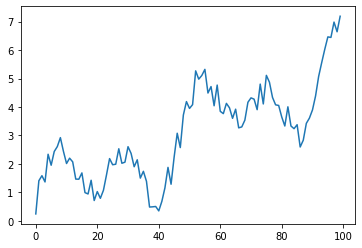

In [48]:
#noisy sample

t = np.linspace(0, 1, 100)
X = np.sin(4.25*np.pi*t) + np.sin(8.5*np.pi*t) + 5*t + np.random.uniform(size=100)
plt.plot(X)

# model = create_model(len(X))
# hist = model.fit(t, X, epochs=3000, verbose=0)
# prediction = model.predict(np.linspace(0, 2, 200)).flatten()
# plt.plot(prediction, color='blue')



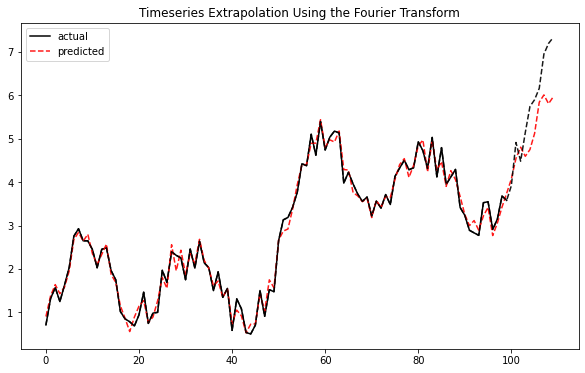

In [195]:
def extrapolate_fourier(x: np.ndarray, 
                        num_steps: int, 
                        num_harmonics: int = 10) -> np.ndarray:
    """
    Predict Timeseries using Fourier Transform
    ---------------
        PARAMS
    ---------------
        1. 'x' -> data values
        2. 'num_steps' -> How many timesteps ahead to predict
        3. 'num_harmonics' -> Number of harmonics to consider
    ---------------
    Adapted From: https://gist.github.com/tartakynov/83f3cd8f44208a1856ce
    ---------------
    """
    n = x.size
    t = np.arange(n)
    m, _ = np.polyfit(t, x, 1)
    x = x - m * t        # detrend x
    x_fdomain = scipy.fft.fft(x)  # translate to frequency domain
    f = scipy.fft.fftfreq(n)  
    idxs = list(t)
    #we want the amplitude peaks -- so we sort idxs by amplitude, descending order
    idxs.sort(key=lambda i: np.absolute(x_fdomain[i])) 
    idxs.reverse()
    t = np.arange(n + num_steps)
    yhat = np.zeros(t.size)
    for i in idxs[:1 + num_harmonics * 2]:
        amp = np.absolute(x_fdomain[i]) / n 
        phase = np.angle(x_fdomain[i]) 
        yhat += amp * np.cos(2 * np.pi * f[i] * t + phase)
    return yhat + m * t
        

t = np.linspace(0, 1, 110)
X = np.sin(4.25*np.pi*t) + np.sin(8.5*np.pi*t) + 5*t + np.random.uniform(size=110)

X_new = X[-10:]
X = X[:-10]

plt.figure(figsize=(10,6))
plt.plot(X, c="black", label="actual")
plt.plot(extrapolate_fourier(X, num_steps=10, num_harmonics=20), 
         linestyle="--", 
         c="red", 
         alpha=0.9, 
         label="predicted")

plt.plot(np.concatenate([X,X_new]), c="black", linestyle="--", alpha=0.9)
plt.legend()
plt.title("Timeseries Extrapolation Using the Fourier Transform")
plt.show()


So what does this have to do with stock prices? Well, what if we could represent price movement as a complex symphony of "chords" comprised of a number of smaller "notes", each affecting the overall movement in different ways? 

And like a musical piece, what if we could show that these chords, and subsequently their subcomponent notes, change over time depending on a number of conditions? 

To state it simply: What if we could represent the price of a stock by the smaller movements that make it up? 

As you will see, this is precisely what I intend to do in this article.


In [196]:
df = pd.read_csv("Data/SPY.csv")
df


,date,close,high,low,open,volume
0,1993-01-29T00:00:00.000Z,25.791527,25.809842,25.681464,25.809842,1003200
1,1993-02-01T00:00:00.000Z,25.974966,25.974966,25.809842,25.809842,480500
2,1993-02-02T00:00:00.000Z,26.029968,26.048342,25.901590,25.956593,201300
3,1993-02-03T00:00:00.000Z,26.305156,26.323471,26.048342,26.066656,529400
4,1993-02-04T00:00:00.000Z,26.415220,26.470222,26.103344,26.396846,531500
...,...,...,...,...,...,...
7156,2021-06-30T00:00:00.000Z,428.060000,428.780000,427.180000,427.210000,64827858
7157,2021-07-01T00:00:00.000Z,430.430000,430.600000,428.800000,428.870000,53441027
7158,2021-07-02T00:00:00.000Z,433.720000,434.100000,430.521800,431.670000,57697668
7159,2021-07-06T00:00:00.000Z,432.930000,434.010000,430.010000,433.780000,68710419


First off, lets prove that we can indeed utilize the Fourier Transform (and its inverse) to decompose stock prices into its component parts.

In [201]:
prices = df.close.values

#randomly subsample 
num_timesteps = 250
start_idx = np.random.randint(0, len(prices)-1)
end_idx = start_idx + num_timesteps
x = prices[start_idx:end_idx]


Root Mean Squared Error: 1.6934187794693377e-14


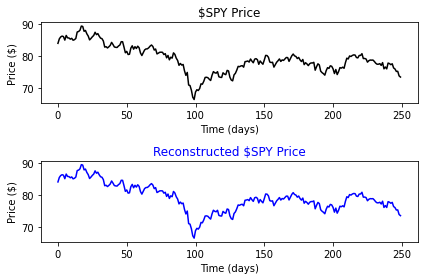

In [202]:
def mse(y: np.ndarray, yhat: np.ndarray) -> float:
    return np.square(np.subtract(y, yhat)).mean()

def rmse(y: np.ndarray, yhat: np.ndarray) -> float:
    return np.sqrt(mse(y, yhat))

fft = scipy.fft.fft(x)
x_reconstructed = scipy.fft.ifft(fft)
print(f"Root Mean Squared Error: {rmse(x, np.abs(x_reconstructed))}")

plt.subplot(2, 1, 1)
plt.plot(x.flatten(), c="black")
plt.title('$SPY Price')
plt.xlabel('Time (days)')
plt.ylabel('Price ($)')

plt.subplot(2, 1, 2)
plt.plot(x_reconstructed, c="blue")
plt.title('Reconstructed $SPY Price', color="blue")
plt.xlabel('Time (days)')
plt.ylabel('Price ($)')

plt.tight_layout()
plt.show()


We will first define a few functions to help us meaure how accurately we can reconstruct prices, namely Mean-Squared Error and the square-root of this (Root Mean-Squared Error). Then, we will use the fourier transform to translate prices into the frequency domain, before using the inverse fourier transform to reconstruct the signal.

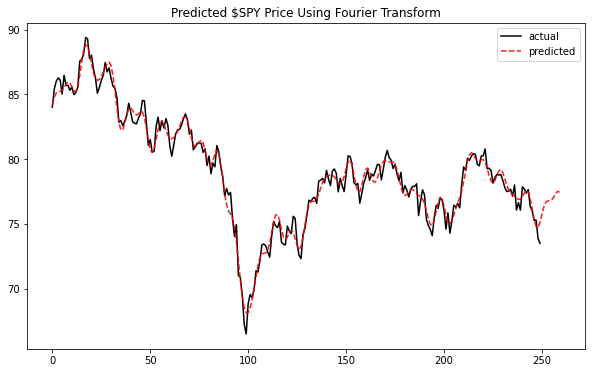

In [204]:
x_predicted = extrapolate_fourier(x, num_steps=10, num_harmonics=20)

plt.figure(figsize=(10,6))
plt.plot(x, c="black", label="actual")
plt.plot(x_predicted, linestyle="--", c="red", alpha=0.9, label="predicted")
plt.legend()
plt.title("Predicted $SPY Price Using Fourier Transform")
plt.show()


As you can see by our very small error, and by the resulting plots, the fourier transform is indeed capable of decomposing and reconstructing prices. This was, of course, expected. 




A few months ago, I came across the paper titled "Neural Decomposition of Time-Series Data for Effective Generalization", which I will link here: https://arxiv.org/pdf/1705.09137.pdf


The Fourier Transform is capable of (almost) perfectly modeling a timeseries with known values. For example, take a look at the below, where we break down the price movements of SPY and reconstruct it the resulting sinusoids. 



As you can see, the Fourier Transform is capable of modeling a timeseries with known values in a near-perfect fashion (our virtually null low root mean-squared error is a testament to this). 

Because of this fact, it was only natural for my mind to wonder: can we use the Fourier Transform to forecast prices into the future as well?

There are obvious problems with this method. For instance, the fourier transform models periodic signals. And while stocks may have some periodic components, they are move inherently in a chaotic fashion.




## Fourier Analysis

The history of the Fourier Transform stems back to 1822, when French phsyicist Joseph Fourier observed that some functions can be represented as the sum of sines. Over time, his theories were tweaked to the give us the Fourier Transform, which essentially states that a signal in the time domain can be represented as the sum of selected sinusoids. Sinusoids, in turn, can be described be amplitude, phase, and frequency


## The Fourier Transform as a Neural Net

https://sidsite.com/posts/fourier-nets/

https://publik.tuwien.ac.at/files/PubDat_171587.pdf


What's kind of cool about the Discrete Fourier Transform is that we can view it as a single-layer neural network with no bias or activation function.



The DFT is calculated as follows:

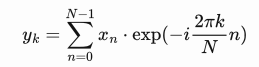


Here 'N' is the length of the signal, 'n' is the current timestep within range 0 <= n < N, 'x(n)' is the signal's value at timestep 'n', and 'k' the frequency.

In english, this is saying that a signal can be written as the sum of sinusoids

y(k) is a complex value that tells us about the sinusoid of frequency 'k' in signal 'x'.


In [16]:
# import numpy as np
# import matplotlib.pyplot as plt

# def create_fourier_weights(signal_length):  
#     k_vals, n_vals = np.mgrid[0:signal_length, 0:signal_length]
#     theta_vals = 2 * np.pi * k_vals * n_vals / signal_length
#     return np.hstack([np.cos(theta_vals), -np.sin(theta_vals)])

# # Generate data:
# signal_length = 64
# x = np.random.random(size=[1, signal_length]) - 0.5

# # Compute Fourier transform using method described above:
# W_fourier = create_fourier_weights(signal_length)
# y = np.matmul(x, W_fourier)

# # Compute Fourier transform using the fast Fourier transform: 
# fft = np.fft.fft(x)
# y_fft = np.hstack([fft.real, fft.imag])

# # Compare the results:
# print('rmse: ', np.sqrt(np.mean((y - y_fft)**2)))
# #the small error here confirms we are calculating the dft correctly with our weights





In [17]:
# y_real = y[:, :signal_length]
# y_imag = y[:, signal_length:]
# tvals = np.arange(signal_length).reshape([-1, 1])
# freqs = np.arange(signal_length).reshape([1, -1])
# arg_vals = 2 * np.pi * tvals * freqs / signal_length
# sinusoids = (y_real * np.cos(arg_vals) - y_imag * np.sin(arg_vals)) / signal_length
# reconstructed_signal = np.sum(sinusoids, axis=1)

# print('rmse:', np.sqrt(np.mean((x - reconstructed_signal)**2)))
# plt.subplot(2, 1, 1)
# plt.plot(x[0,:])
# plt.title('Original signal')
# plt.subplot(2, 1, 2)
# plt.plot(reconstructed_signal)
# plt.title('Signal reconstructed from sinusoids after DFT')
# plt.tight_layout()
# plt.show()


In [18]:
# price_df = pd.read_csv("Data/SPY.csv")
# prices = price_df.close.values


So we know the fourier transform can reconstruct known prices perfectly, but in order to predict prices, we'll need to test whether or not the fourier transform can extrapolate into the future. 




## Using the iDFT to Forecast 

One approach for analyzing time-series data is to interpret it as a signal and apply the Fourier transform to decompose the data into a sum of sinusoids.

The Fourier transform uses a predetermined set of sinusoid frequencies rather than learning the frequencies that are actually expressed in the training data

Although the signal produced by the Fourier transform perfectly reproduces the training samples, it also predicts that the same pattern of samples will repeat indefinitely

As a result, the Fourier transform is effective at interpolation but is unable to extrapolate future values. Another limitation of the Fourier transform is that it only uses periodic components, and thus cannot accurately model the nonperiodic aspects of a signal, such as a linear trend or nonlinear abnormality.

The harmonic analysis of a signal transforms a set of samples from the time domain to the frequency domain

What is a harmonic? A harmonic is a wave with a frequency that is a multiple of the frequency of the original signal, also known as the fundamental frequency.

Harmonic analysis is useful in time-series prediction because the resulting frequencies can be used to reconstruct the original signal (interpolation) and to forecast values beyond the sampled time window (extrapolation)

Perhaps the most popular method of harmonic analysis is the distrete Fourier transform (DFT). The DFT maps a series of N complex numbers in the time domain to the frequency domain. The inverse DFT (iDFT) can be applied these new values to map them back to the time domain.

More interestingly, the iDFT can be used as a continuous representation of the originally discrete input


The DFT and the iDFT are effectively the same transform with two key differences. First, in terms of sinusoids, the DFT uses negative multiples of 2π/N as frequencies and the iDFT uses positive multiples of 2π/N as frequencies. Second, the iDFT contains the normalization term 1/N applied to each sum.


In general, the iDFT requires all N complex values from the frequency domain to reconstruct the input series. For real-valued input, however, only the first N/2 + 1 complex values are necessary (N/2 frequencies and one bias). The remaining complex numbers are the conjugates of the first half of the values, so they only contain redundant information.

The iDFT is as follows. Let Rk and Ik represent the real and imaginary components respectively of the kth complex number returned by the DFT. Let 2πk/N be the frequency of the kth term. The first frequency yields the bias, because cos(0) = 1 and sin(0) = 0. The second frequency is a single wave, the third frequency is two waves, the fourth frequency is three waves, and so on. The cosine with the kth frequency is scaled by Rk, and the sine with the kth frequency is scaled by Ik. Thus, the iDFT is sufficiently described as a sum of N/2 + 1 terms, with a sin(t) and a cos(t) in each term and a complex number from the DFT corresponding to each term:


The iDFT equation below is useful as a continuous representation of the real-valued discrete input


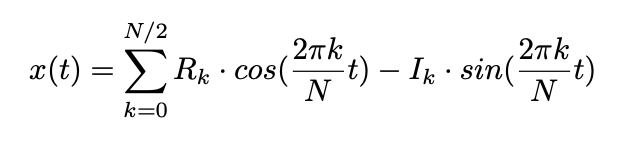


However there is one issue here. In order to choose appropriate frequencies, however, the iDFT assumes that the underlying function always has a period equal to the size of the samples that represent it, that is, x(t + N ) = x(t) for all t.

Typically, in cases where generalization is desirable, the period of the underlying function is not known. The iDFT cannot effectively model the nonperiodic components of a signal, nor can it form a simple model for series that are not periodic at N, even if the series is perfectly periodic.

## Neural Decomp



Let each a represent k
an amplitude, each w represent a frequency, and each φ k k
represent a phase shift. Let g(t) be an augmentation function that represents the nonperiodic components of the signal.

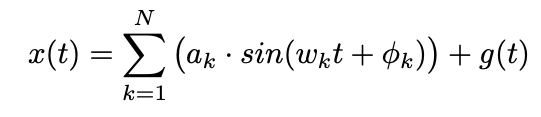


In [265]:
from typing import *
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression


In [88]:
class ND(nn.Module):
    """
    **************
    Neural Decomposition (ND) using Fourier Transforms
    **************
    > ND is based on the inverse Discrete Fourier Transform (iDFT), except the frequencies and phase shifts are 
        trainable. A linear unit g(t) -- called the augmentation function in the paper -- is used to model 
        non-periodic components, something the iDFT cannot do, as the frequencies are frozen.
    > ND initializes its weights to mimic the iDFT, and then these weights are fine-tuned during the training process.
    > To simplify, ND is calcualted via the sum of the sine of frequencies and phase-shifts (instead of sum of N/2 sins and N/2 cosine).
    > 1/N is absorbed by preprocessing for our inputs (by dividing X/N). 
    **************
    > Reference Paper: 
        https://arxiv.org/pdf/1705.09137.pdf
    **************
    *   PARAMS   *
    **************
        1. 'n' -> the length of the sequence
        2. 'linear_units' -> number of output units for each layer making up g(t)
        3. 'num_outputs' -> number of outputs of entire model 
                            NOTE: only built to handle 1 for now; which is default
        4. 'noise' -> Amount of noise to add to g(t) weights
    **************
    *  TOPOLOGY  *
    **************
    For an input of size N, the network is initialized with two layers:
        a. 1 -> m
        b. m -> 1
    where m = N + |g(t)| 
    and |g(t)| denotes the number of nodes required by g(t)
    ***************
    * ACTIVATIONS *
    ***************
    The first N nodes in the hidden layer have a sin(t) activation
    The nodes associated with g(t) can have any combination of activation functions
        a. Linear to measure trend
        b. Sigmoidal to measure non-periodic portions
    ***************
    * WEIGHT INIT *
    ***************
    Each of the N sinusoid nodes in the hidden layer (indexed 0 <= K < N), have a frequency w(k) and phase shift b(k)
    1. Each w(k) set to 2π⌊k/2⌋
    
    2. For each even value of k, b(k) set to π/2
        - This transforms sin(t + b(k)) to cos(t)
        
    3. For each odd value of k, b(k) set to π
        - This transforms sin(t + b(k)) to −sin(t)

    4. Weights in hidden layer associated with g(t) are initialzied to approximate identity
        y = w(t) + b
        > w randomly perturbed from 1
        > b randomly perturbed from 0
            
    5. All weights feeding into the output layer are set to small random values
    **************
    """
    def __init__(self, 
                 n: int, 
                 linear_units: int, 
                 noise: float = 0.001):
        super(ND, self).__init__()

        self.wave = nn.Linear(1, n)
        self.unit_linear = nn.Linear(1, linear_units) #g(t) models trend
        self.unit_lrelu = nn.Linear(1, linear_units) #g(t) models non-periodic componenets
        self.unit_sigmoid = nn.Linear(1, linear_units) #g(t) models non-periodic componenets
        
        self.lrelu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.fc = nn.Linear(n + 3*linear_units, 1) #m -> 1

        params = dict(self.named_parameters())
        #weights represent a frequency
        params['wave.weight'].data = torch.from_numpy((2*np.pi*np.floor(np.arange(n)/2))[:,np.newaxis]).float()
        #bias is phase shift
        params['wave.bias'].data = torch.from_numpy(np.pi/2+np.arange(n)%2*np.pi/2).float()
        
        params['unit_linear.weight'].data = torch.from_numpy(np.ones(shape=(linear_units,1)) + np.random.normal(size=(linear_units,1))*noise).float()
        params['unit_linear.bias'].data = torch.from_numpy(np.random.normal(size=(linear_units))*noise).float()
        
        params['unit_softplus.weight'].data = torch.from_numpy(np.random.normal(size=(linear_units,1))*noise).float()
        params['unit_softplus.bias'].data = torch.from_numpy(np.random.normal(size=(linear_units))*noise).float()
        
        params['unit_sigmoid.weight'].data = torch.from_numpy(np.random.normal(size=(linear_units,1))*noise).float()
        params['unit_sigmoid.bias'].data = torch.from_numpy(np.random.normal(size=(linear_units))*noise).float()
        
        params['fc.weight'].data = torch.from_numpy(np.random.normal(size=(1,n+3*linear_units))*noise).float()
        params['fc.bias'].data = torch.from_numpy(np.random.normal(size=(1))*noise).float()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        sinusoid = torch.sin(self.wave(X)) #sine activation
        linear = self.unit_linear(X)
        lrelu = self.lrelu(self.unit_lrelu(X))
        sigmoid = self.sigmoid(self.unit_sigmoid(X))
        combined = torch.cat([sinusoid, linear, lrelu, sigmoid], dim=1)
        out = self.fc(combined)
        return out
    
    def predict(self, X) -> torch.Tensor:
        with torch.no_grad():
            return self(X)


In [293]:
window = 320
pred_period = 40
N = window - pred_period

start = np.random.randint(len(price_df)-window)

Train shape: (280,) || Test shape: (40,)


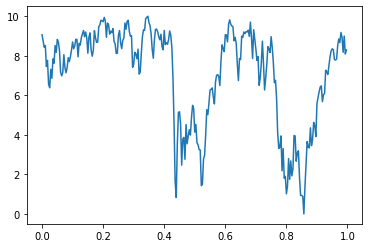

ND(
  (wave): Linear(in_features=1, out_features=300, bias=True)
  (unit_linear): Linear(in_features=1, out_features=1, bias=True)
  (unit_softplus): Linear(in_features=1, out_features=1, bias=True)
  (unit_sigmoid): Linear(in_features=1, out_features=1, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
  (sigmoid): Sigmoid()
  (fc): Linear(in_features=303, out_features=1, bias=True)
)

In [294]:
prices = price_df.close.values[start:start+window]
train_y, test_y = prices[:-pred_period], prices[-pred_period:]

print(f"Train shape: {train_y.shape} || Test shape: {test_y.shape}")

scaler = MinMaxScaler(feature_range=(0, 10))

train_X = (np.arange(N) / N).reshape(-1,1) #perform the 1/N step for calculating the iDFT
#linear regression baseline---
lr = LinearRegression()
lr.fit(train_X, train_y)
#-----------------------------

train_y = scaler.fit_transform(train_y.reshape(-1,1))

test_X = (np.arange(window) / N).reshape(-1,1)
#no sense in scaling test_y too...

plt.plot(train_X, train_y)
plt.show()

train_X = torch.from_numpy(train_X).float()
train_X.requires_grad = True

train_y = torch.from_numpy(train_y).float()
train_y.requires_grad = True

nd = ND(X.shape[0], linear_units=1)
nd

In [295]:
# Loss and Optimizer
criterion = nn.MSELoss()
#paper used 10e-3 learning rate with SGD -- we'll use Adam
optimizer = torch.optim.Adam(nd.parameters(), lr=1e-3)  
# Train the Model
for epoch in range(1, 5001):
    optimizer.zero_grad()  # zero the gradient buffer
    yhat = nd.forward(train_X)
    loss = criterion(yhat, train_y)

    # Add L1 to loss -- in paper they used 10e-2
    loss += 0.09*torch.sum(torch.abs(dict(nd.named_parameters())['fc.weight']))
    #loss += 0.05*torch.sum(torch.abs(dict(nd.named_parameters())['unit_linear.weight']))

    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print (f"Epoch {epoch}, Loss: {loss.item():.4f}")
        


Epoch 1000, Loss: 2.1923
Epoch 2000, Loss: 1.6073
Epoch 3000, Loss: 1.5732
Epoch 4000, Loss: 1.5333
Epoch 5000, Loss: 1.4921


Train Mean Abs Perc Error: 0.53%
Test Mean Abs Perc Error: 1.36%


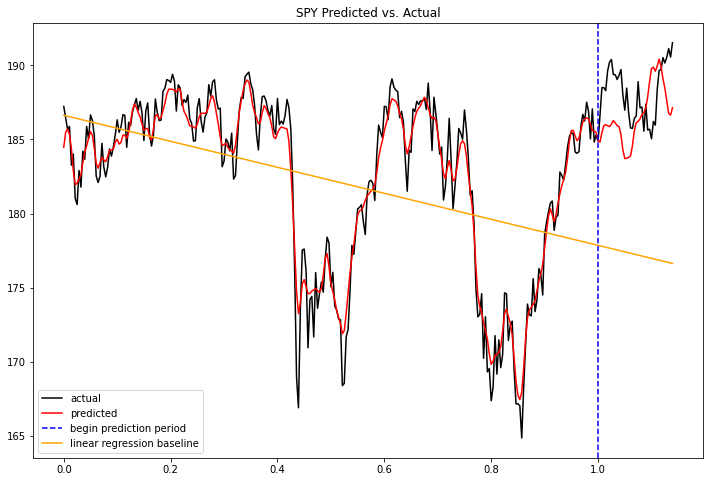

In [296]:
with torch.no_grad():
    yhat = nd(torch.from_numpy(test_X).float()).numpy()

yhat = scaler.inverse_transform(yhat).flatten() 

train_error = mean_absolute_percentage_error(prices[:-pred_period], yhat[:-pred_period])
test_error = mean_absolute_percentage_error(prices[-pred_period:], yhat[-pred_period:])

print(f"Train Mean Abs Perc Error: {train_error*100:.2f}%")
print(f"Test Mean Abs Perc Error: {test_error*100:.2f}%")

lr_baseline = lr.predict(test_X)

plt.figure(figsize=(12,8))
plt.plot(test_X.flatten(), prices, c="black", label="actual")
plt.plot(test_X.flatten(), yhat, c="red", label="predicted")
plt.axvline(1.0, c="blue", linestyle="dashed", label="begin prediction period")
plt.plot(test_X.flatten(), lr_baseline, color="orange", label="linear regression baseline")
plt.legend()
plt.title("SPY Predicted vs. Actual")
plt.show()





In [258]:
class ND_HLC(nn.Module):
    def __init__(self, n: int, linear_units: int):
        super(ND_HLC, self).__init__()
        self.c = ND(n=n, linear_units=linear_units)
        self.h = ND(n=n, linear_units=linear_units)
        self.l = ND(n=n, linear_units=linear_units)
        self.fc_out = nn.Linear(3,3)
    
    def forward(self, X):
        out = torch.cat([self.c(X), 
                         self.h(X), 
                         self.l(X)], dim=1)
        out = self.fc_out(out)
        return out
    

Train shape: (300, 3) || Test shape: (20, 3)


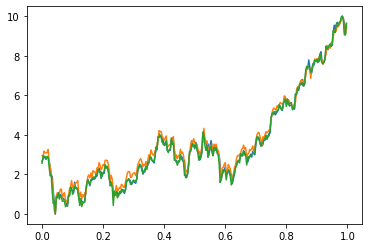

ND_HLC(
  (c): ND(
    (wave): Linear(in_features=1, out_features=300, bias=True)
    (unit_linear): Linear(in_features=1, out_features=1, bias=True)
    (unit_softplus): Linear(in_features=1, out_features=1, bias=True)
    (unit_sigmoid): Linear(in_features=1, out_features=1, bias=True)
    (softplus): Softplus(beta=1, threshold=20)
    (sigmoid): Sigmoid()
    (fc): Linear(in_features=303, out_features=1, bias=True)
  )
  (h): ND(
    (wave): Linear(in_features=1, out_features=300, bias=True)
    (unit_linear): Linear(in_features=1, out_features=1, bias=True)
    (unit_softplus): Linear(in_features=1, out_features=1, bias=True)
    (unit_sigmoid): Linear(in_features=1, out_features=1, bias=True)
    (softplus): Softplus(beta=1, threshold=20)
    (sigmoid): Sigmoid()
    (fc): Linear(in_features=303, out_features=1, bias=True)
  )
  (l): ND(
    (wave): Linear(in_features=1, out_features=300, bias=True)
    (unit_linear): Linear(in_features=1, out_features=1, bias=True)
    (unit_soft

In [245]:
# window = 320
# pred_period = 20
# N = window - pred_period
# start = np.random.randint(len(price_df)-window)

prices = price_df[["high", "low", "close"]].values[start:start+window]
train_y, test_y = prices[:-pred_period], prices[-pred_period:]
print(f"Train shape: {train_y.shape} || Test shape: {test_y.shape}")

scaler = MinMaxScaler(feature_range=(0, 10))

train_X = (np.arange(N) / N).reshape(-1,1) #perform the 1/N step for calculating the iDFT
train_y = scaler.fit_transform(train_y)

test_X = (np.arange(window) / N).reshape(-1,1)
# #no sense in scaling test_y too...
plt.plot(train_X, train_y)
plt.show()


train_X = torch.from_numpy(train_X).float()
train_X.requires_grad = True

train_y = torch.from_numpy(train_y).float()
train_y.requires_grad = True


nd = ND_HLC(train_X.shape[0], linear_units=1)
print(nd)

In [246]:
# Loss and Optimizer
criterion = nn.MSELoss()
#paper used 10e-3 learning rate with SGD -- we'll use Adam
optimizer = torch.optim.Adam(nd.parameters(), lr=1e-2)  
# Train the Model
for epoch in range(1, 5001):
    optimizer.zero_grad()  # zero the gradient buffer
    yhat = nd.forward(train_X)
    loss = criterion(yhat, train_y)
    
    #L1 regularization to fully connected layers 
    loss += 0.07*torch.sum(torch.abs(dict(nd.named_parameters())['c.fc.weight']))
    loss += 0.03*torch.sum(torch.abs(dict(nd.named_parameters())['h.fc.weight']))
    loss += 0.03*torch.sum(torch.abs(dict(nd.named_parameters())['l.fc.weight']))

    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print (f"Epoch {epoch}, Loss: {loss.item():.4f}")
        

Epoch 1000, Loss: 0.2116
Epoch 2000, Loss: 0.1484
Epoch 3000, Loss: 0.1205
Epoch 4000, Loss: 0.1050
Epoch 5000, Loss: 0.0965


In [247]:
with torch.no_grad():
    yhat = nd(torch.from_numpy(test_X).float()).numpy()

yhat = scaler.inverse_transform(yhat) 
yhat_max = np.max(yhat, axis=1)
yhat_min = np.min(yhat, axis=1)


Train Mean Abs Perc Error: 0.20%
Test Mean Abs Perc Error: 4.42%


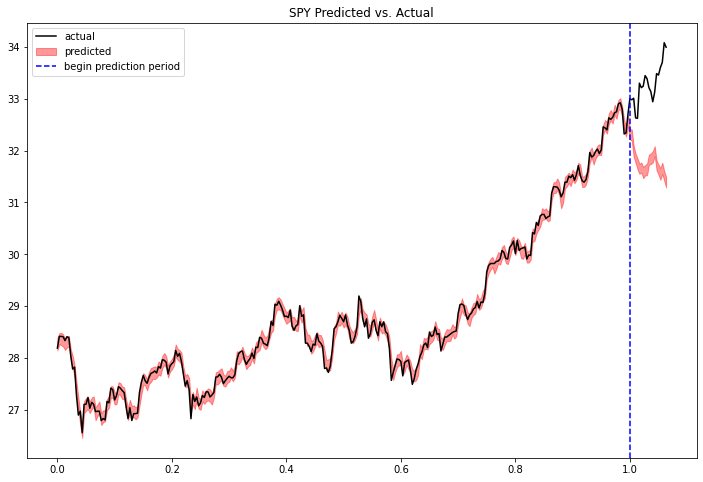

In [248]:
train_error = mean_absolute_percentage_error(prices[:-pred_period], yhat[:-pred_period])
test_error = mean_absolute_percentage_error(prices[-pred_period:], yhat[-pred_period:])

print(f"Train Mean Abs Perc Error: {train_error*100:.2f}%")
print(f"Test Mean Abs Perc Error: {test_error*100:.2f}%")


plt.figure(figsize=(12,8))
plt.plot(test_X.flatten(), prices[:,2], c="black", label="actual")
plt.fill_between(test_X.flatten(), 
                 yhat_min, yhat_max, 
                 color="red", 
                 alpha=0.4, 
                 label="predicted")

#plt.plot(test_X.flatten(), yhat, c="red", label="predicted")
plt.axvline(1.0, c="blue", linestyle="dashed", label="begin prediction period")
plt.legend()
plt.title("SPY Predicted vs. Actual")
plt.show()

In [ ]:
# def run_tests(num_sample_periods: int, 
#               window: int, 
#               split_perc: float) -> dict:
    
#     results = {"nd_err": [], "idft_err": [], "std": [], "nd_directonal":[], ""}
#     for pd in range(num_sample_periods):
#         train_y, test_y = prices.sample_split(num_timesteps=window, split_perc=0.15)
#         y = np.concatenate([train_y, test_y])

#         pred_period = test_y.size
#         N = train_y.size
        
#         fourier_extrap_yhat = extrapolate_fourier(train_y, num_steps=pred_period, num_harmonics=20)


#         train_X = (np.arange(N) / N).reshape(-1,1) #perform the 1/N step for calculating the iDFT

#         scaler = MinMaxScaler(feature_range=(0, 5))
#         train_y = scaler.fit_transform(train_y.reshape(-1,1))

#         test_X = (np.arange(window) / N).reshape(-1,1)

#         train_X = torch.from_numpy(train_X).float()
#         train_X.requires_grad = True

#         train_y = torch.from_numpy(train_y).float()
#         train_y.requires_grad = True

#         nd = ND(n=N, linear_units=1)
#         nd.fit(X=train_X, y=train_y, num_epochs=3000, lr=1e-3, l1_reg=0.05, print_every=-1)
        
#         yhat = nd.predict(torch.from_numpy(test_X).float()).numpy()
#         yhat = scaler.inverse_transform(yhat).flatten() 

#         train_y = scaler.inverse_transform(train_y.detach().numpy()).flatten()
        
#         nd_test_error = mean_absolute_percentage_error(test_y, yhat[-pred_period:])
#         idft_test_error = mean_absolute_percentage_error(test_y, fourier_extrap_yhat[-pred_period:])
        
#         results["nd"].append(nd_test_error)
#         results["idft"].append(idft_test_error)
#         results["std"].append(np.std(y))
#     return results
        

# results = run_tests(250, 150, 0.15)

In [ ]:
# import json
# with open("test_results_ss200_w300.json", "w+") as f:
#     json.dump(results, f)



In [ ]:
# np.mean(results["nd"]), np.mean(results["idft"])

In [ ]:
# sigma = np.mean(results["std"]) + np.std(results["std"])
# sigma_idxs = np.argwhere(results["std"] > sigma).flatten()

# np.mean(np.array(results["nd"])[sigma_idxs]), np.mean(np.array(results["idft"])[sigma_idxs])